In [10]:
import numpy as np
from scipy.sparse import linalg as spla
from scipy.io import loadmat
import graphlearning as gl
from matplotlib import pyplot as plt
import random

In [34]:
def get_dataset():
    img = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    # Save dataset
    X = img.reshape(-1, 200)
    gl.save_dataset(X, 'indian_pines', overwrite=True)

    # Save labels
    L = gt.reshape(-1)
    gl.save_labels(L, 'indian_pines', overwrite=True)

    # To add a dataset to the simulation environment, we also need
    # to save a label permutation, which is a number of random train/test splits
    # and store some precomputed knn-data

    # Create label permutation with 100 trials at 1,2,3,4,5 labels per class
    # You can add any identifying string as name='...' if you need to create additional
    # label permutations for a dataset.
#     gl.create_label_permutations(L, 100, [1,2,3,4,5], dataset='indian_pines', name=None, overwrite=True)

    # Run knn search and save info on 30 nearest neighbors
    # Choose as many as you are likely to use in practice, the code will automatically subset if needed.
    # This uses a kd-tree. For higher dimensional data use the annoy package, as below
    I, J, D = gl.knnsearch_annoy(X, 30, dataset='indian_pines')
    # I, J, D = gl.knnsearch(X, 30, dataset='indian_pines')
    return I, J, D,img
    
I, J, D, img = get_dataset()

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


<img src="high_level_overview.png"/>

In [43]:
def loop(iters = 100,added_label = 25):
#   initialize
    labels = gl.load_labels('indian_pines')
    train_ind = gl.randomize_labels(labels, 1)
    tau = .1
    idxs = range(len(list(labels)))
    pred_labels = []
    # Get Weight Matrix and Adjusted Graph Laplacian
    W = gl.weight_matrix(I, J, D, 10)
    L = gl.graph_laplacian(W, norm='none') + tau**2*gl.sparse.identity(W.shape[0])
#     while acc < .01:
        # Run SSL
    accuracy = []
    percentage = []
    i = 0
    while i < iters:
        train_labels = labels[train_ind]
        pred_labels = gl.graph_ssl(W, train_ind, train_labels, algorithm='laplace')
        # Calculate Accuracy
        acc = np.sum(pred_labels == labels) / len(labels)
        accuracy.append(acc)
#         print('Accuracy:', acc)
        idxs  = list(set(idxs) - set(train_ind))
        new_ind = random.choices(idxs,k = added_label)
        train_ind = list(train_ind) + new_ind 
        percentage.append(len(train_ind)/len(labels))
        i+=1
    return accuracy,percentage,pred_labels

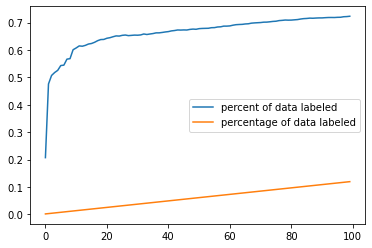

In [44]:
acc,perc,pred = loop()

plt.plot(acc,label = 'percent of data labeled')
plt.plot(perc,label = 'percentage of data labeled')
plt.legend()
plt.show()

In [36]:
#pick random points and retrain model
# l

In [9]:
set([1,2,3])-set([2,3,4])

{1}

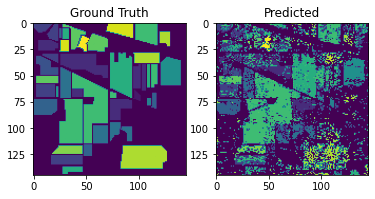

In [48]:
img = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
plt.subplots(12)
plt.subplot(121)
plt.title('Ground Truth')
plt.imshow(img)
plt.subplot(122)
plt.title(122)
plt.title('Predicted')
plt.imshow(pred.reshape(145,145))


In [42]:
img.shape

(145, 145)

In [45]:
pred2 = pred.reshape(145,145)

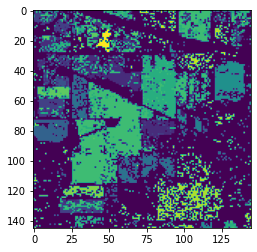

In [46]:
plt.imshow(pred2)

In [ ]:
#active learning
def active_loop(iters = 100,added_label = 25):
#   initialize
    labels = gl.load_labels('indian_pines')
    train_ind = gl.randomize_labels(labels, 1)
    tau = .1
    idxs = range(len(list(labels)))
    pred_labels = []
    # Get Weight Matrix and Adjusted Graph Laplacian
    W = gl.weight_matrix(I, J, D, 10)
    L = gl.graph_laplacian(W, norm='none') + tau**2*gl.sparse.identity(W.shape[0])
#     while acc < .01:
        # Run SSL
    accuracy = []
    percentage = []
    i = 0
    while i < iters:
        train_labels = labels[train_ind]
        pred_labels = gl.graph_ssl(W, train_ind, train_labels, algorithm='laplace')
        # Calculate Accuracy
        acc = np.sum(pred_labels == labels) / len(labels)
        accuracy.append(acc)
#         print('Accuracy:', acc)
        idxs  = list(set(idxs) - set(train_ind))
        #calculating the most valuable points to add
        
        
        # adding the most valuable data points
        
        
        new_ind = random.choices(idxs,k = added_label)
        train_ind = list(train_ind) + new_ind 
        percentage.append(len(train_ind)/len(labels))
        i+=1
    return accuracy,percentage,pred_labels